In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import datetime

from sklearn import preprocessing

from sklearn.model_selection import train_test_split, KFold

import warnings
warnings.filterwarnings('ignore')

### 1. Preprocessing

In [2]:
le = preprocessing.LabelEncoder()

u_df = pd.read_csv('users.dat',sep='::', names = ['UserID','Gender','Age','Occupation','Zipcode'])

le.fit(u_df.UserID)
u_df['U_ID'] = le.transform(u_df.UserID)

u_df.tail()

,UserID,Gender,Age,Occupation,Zipcode,U_ID
6035,6036,F,25,15,32603,6035
6036,6037,F,45,1,76006,6036
6037,6038,F,56,1,14706,6037
6038,6039,F,45,0,01060,6038
6039,6040,M,25,6,11106,6039


In [3]:
m_df = pd.read_csv('movies.dat',sep='::', names = ['MovieID','Title','Genres'])

le.fit(m_df.MovieID)
m_df['M_ID'] = le.transform(m_df.MovieID)

m_df.tail()

,MovieID,Title,Genres,M_ID
3878,3948,Meet the Parents (2000),Comedy,3878
3879,3949,Requiem for a Dream (2000),Drama,3879
3880,3950,Tigerland (2000),Drama,3880
3881,3951,Two Family House (2000),Drama,3881
3882,3952,"Contender, The (2000)",Drama|Thriller,3882


In [4]:
a = m_df.Genres.tolist()
set('|'.join(a).split('|'))

{'Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

In [5]:
r_df = pd.read_csv('ratings.dat',sep='::', names = ['UserID','MovieID','Rating','Time'])

le.fit(u_df.UserID)
r_df['U_ID'] = le.transform(r_df.UserID)
le.fit(m_df.MovieID)
r_df['M_ID'] = le.transform(r_df.MovieID)

r_df.head(10)

,UserID,MovieID,Rating,Time,U_ID,M_ID
0,1,1193,5,978300760,0,1176
1,1,661,3,978302109,0,655
2,1,914,3,978301968,0,902
3,1,3408,4,978300275,0,3339
4,1,2355,5,978824291,0,2286
5,1,1197,3,978302268,0,1179
6,1,1287,5,978302039,0,1267
7,1,2804,5,978300719,0,2735
8,1,594,4,978302268,0,590
9,1,919,4,978301368,0,907


### 2. Rating Model

In [6]:
def rating_class(X, MIU, BU, BI, PU, QI):
    users=X[:,0]
    items=X[:,1]
    R = MIU+BU[users]+BI[items]+np.dot(PU,QI.T)[users,items]
    R[R<1]=1; R[R>5]=5
    return R   # U*I

### 3 & 4. Data Sets

In [7]:
# Training size
r_trainval, r_test = train_test_split(r_df, test_size = 0.15)
r_train, r_val = train_test_split(r_trainval, test_size = 0.15)
r_train.shape, r_val.shape, r_test.shape, r_df.shape

((722650, 6), (127527, 6), (150032, 6), (1000209, 6))

### 5. Parameter Initialization

In [8]:
def param_initial(F,U,I):
    BU = np.random.normal(0,np.sqrt(1e-4),U)
    BI = np.random.normal(0,np.sqrt(1e-4),I)
    PU = np.random.normal(0,np.sqrt(1/max(1,np.sqrt(F))),(U,F))
    QI = np.random.normal(0,np.sqrt(1/max(1,np.sqrt(F))),(I,F))
    return BU,BI,PU,QI

### 6. Loss Function & Stochastic Gradient Descent Function
#### i. Loss Function

In [2]:
def loss_function(X, R, penalty, MIU, BU, BI, PU, QI, msg=None):
    users=X[:,0]
    items=X[:,1]
    R_pred = rating_class(X, MIU, BU, BI, PU, QI)
    mse = np.mean((R-R_pred)**2)
    if penalty>0 and PU.shape[1]:
        mse += 0.5*penalty*((PU[users]**2).mean() + (QI[items]**2).mean())
    if msg:
        absolute_accuracy = np.mean(abs(R-R_pred)<=0.5)
        relative_accuracy = np.mean(abs(R-R_pred)<=1)
        date_str=datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        print(f"{date_str} | {msg} Loss {mse:.6f}") #,  Acc {relative_accuracy:.6f}")
        return mse, relative_accuracy
    return mse

#### ii. Stochastic Gradient Descent Function

In [178]:
def StoGradient(X, R, penalty, MIU, BU, BI, PU, QI):
    users=X[:,0]
    items=X[:,1]    
    R_pred=rating_class(X, MIU, BU, BI, PU, QI)
    delta=(R-R_pred)
    g_bu = -delta
    g_bi = -delta
    g_pu = -QI[items]*delta[:,np.newaxis]
    g_qi = -PU[users]*delta[:,np.newaxis]
    if penalty>0:
        g_pu+=penalty*PU[users]
        g_qi+=penalty*QI[items]
    return g_bu, g_bi, g_pu, g_qi

In [122]:
def Optimize_SGD(X, R, MIU, BU, BI, PU, QI, F,
                  penalty=0, learning_rate=0.001, batch_size=1000, tol=1e-6, max_iter=100, verbose=True, report_time=1):
    users=X[:,0]
    items=X[:,1]   
    if verbose: loss0 = loss_function(X, R, penalty, MIU, BU, BI, PU, QI, msg='Original')[0]
    else: loss0 = loss_function(X, R, penalty, MIU, BU, BI, PU, QI, msg=None)
    N=len(R)
    for e in range(max_iter):
        if (e%(max_iter//report_time)==0 and verbose): loss_function(X, R, penalty, MIU, BU, BI, PU, QI, msg='TRAIN')             
#         perm=np.random.permutation(N)
        for i in range(0, N, batch_size):
            Xb = X[i:i+batch_size]
            Rb = R[i:i+batch_size]
            u_b=Xb[:,0]
            i_b=Xb[:,1]
            p = len(Rb)/N*penalty
            miu = np.mean(Rb)
            gradBU,gradBI,gradP,gradQ = StoGradient(Xb, Rb, p, miu, BU, BI, PU, QI)
            try:
                gu = pd.concat([pd.DataFrame(u_b,columns=['idx']),pd.Series(gradBU),pd.DataFrame(gradP)],axis=1).groupby('idx').mean()
                gi = pd.concat([pd.DataFrame(i_b,columns=['idx']),pd.Series(gradBI),pd.DataFrame(gradQ)],axis=1).groupby('idx').mean()
            except:
                gu = pd.concat([pd.DataFrame(u_b,columns=['idx']),pd.Series(gradBU)],axis=1).groupby('idx').mean()
                gi = pd.concat([pd.DataFrame(i_b,columns=['idx']),pd.Series(gradBI)],axis=1).groupby('idx').mean()   
            BU[gu.index]-=learning_rate*np.array(gu.iloc[:,0])
            BI[gi.index]-=learning_rate*np.array(gi.iloc[:,0]) 
            PU[gu.index]-=learning_rate*np.array(gu.iloc[:,1:])
            QI[gi.index]-=learning_rate*np.array(gi.iloc[:,1:])           
#             BU[u_b]-=learning_rate*gradBU 
#             BI[i_b]-=learning_rate*gradBI 
#             PU[u_b]-=learning_rate*gradP
#             QI[i_b]-=learning_rate*gradQ
        loss = loss_function(X, R, penalty, MIU, BU, BI, PU, QI, msg=None)
        d=np.abs(loss-loss0)
        if (d<tol*loss0): break
        elif (d>loss0) or (loss>loss0):
            print('\tOvershoot!')
            return BU, BI, PU, QI
            break
        loss0=loss
    if verbose and d<loss0: loss_function(X, R, penalty, MIU, BU, BI, PU, QI, msg='TRAIN')
    return BU, BI, PU, QI

### 7. Learning Rate

In [11]:
X=np.array(r_train[['U_ID','M_ID']])
R=np.array(r_train['Rating'])

U = len(pd.unique(u_df.U_ID))
I = len(pd.unique(m_df.M_ID))
    
train_list=[]
results=[]

miu = np.mean(R)

B=10000  # batch size
p=1      # penalty
T = 5    # epochs: very few here, just for learning rate selection
F = 0

# learning_rate
rates = [.5,.1,.01,.001,.0005,.0001]

for r in rates:
    print('Learning Rate:',r)
    BU_guess,BI_guess,PU_guess,QI_guess = param_initial(F,U,I)
    BU, BI, PU, QI = Optimize_SGD(X, R, miu, BU_guess,BI_guess,PU_guess,QI_guess, F,
                                  penalty=p, learning_rate=r, batch_size=B, tol=1e-6, max_iter=T, verbose=True, report_time=2)
    
    train_mse = loss_function(X, R, p, miu, BU, BI, PU, QI)
    train_list.append(train_mse)
    results.append((r,train_mse))
    
r_validation = pd.DataFrame(results,columns=["Learning Rate","Train MSE"])
best_r = r_validation["Learning Rate"][r_validation['Train MSE'].idxmin(axis=0)]
r_validation

Learning Rate: 0.5
2019-11-20 16:38:35 | Original Loss 1.247709
2019-11-20 16:38:35 | TRAIN Loss 1.247709
2019-11-20 16:38:49 | TRAIN Loss 1.108521
2019-11-20 16:39:03 | TRAIN Loss 1.108499
2019-11-20 16:39:10 | TRAIN Loss 1.108499
Learning Rate: 0.1
2019-11-20 16:39:10 | Original Loss 1.247799
2019-11-20 16:39:10 | TRAIN Loss 1.247799
2019-11-20 16:39:24 | TRAIN Loss 0.830356
2019-11-20 16:39:38 | TRAIN Loss 0.830079
2019-11-20 16:39:45 | TRAIN Loss 0.830023
Learning Rate: 0.01
2019-11-20 16:39:45 | Original Loss 1.247400
2019-11-20 16:39:45 | TRAIN Loss 1.247400
2019-11-20 16:39:59 | TRAIN Loss 0.850987
2019-11-20 16:40:14 | TRAIN Loss 0.817399
2019-11-20 16:40:21 | TRAIN Loss 0.812908
Learning Rate: 0.001
2019-11-20 16:40:21 | Original Loss 1.247550
2019-11-20 16:40:21 | TRAIN Loss 1.247550
2019-11-20 16:40:35 | TRAIN Loss 1.141875
2019-11-20 16:40:49 | TRAIN Loss 1.063904
2019-11-20 16:40:56 | TRAIN Loss 1.032827
Learning Rate: 0.0005
2019-11-20 16:40:56 | Original Loss 1.248200
20

,Learning Rate,Train MSE
0,0.5000,1.108499
1,0.1000,0.830023
2,0.0100,0.812908
3,0.0010,1.032827
4,0.0005,1.120603
5,0.0001,1.218377


### 8. Validation Performance: Popularity Model

In [15]:
r = 0.01 # Selected learning_rate

BU_guess,BI_guess,PU_guess,QI_guess = param_initial(F,U,I)
BU, BI, PU, QI = Optimize_SGD(X, R, miu, BU_guess,BI_guess,PU_guess,QI_guess, F,
                              penalty=p, learning_rate=r, batch_size=B, tol=1e-6, max_iter=T, verbose=True, report_time=1)

# Validation Set
X_val=np.array(r_val[['U_ID','M_ID']])
R_val=np.array(r_val['Rating'])

val_mse = loss_function(X_val, R_val, p, miu, BU, BI, PU, QI, msg='VAL')[0]
print(f'Popularity Model Validation MSE:{val_mse:.6f}')

2019-11-20 16:43:50 | Original Loss 1.247396
2019-11-20 16:43:50 | TRAIN Loss 1.247396
2019-11-20 16:44:24 | TRAIN Loss 0.812906
2019-11-20 16:44:24 | VAL Loss 0.828550
Popularity Model Validation MSE:0.828550


### 9. Parameters Selection
    B batch-size,  p penalty,  T epoch,  r learning-rate,  F
#### i. Batch-size B

In [124]:
Bs = [1000,5000,8000,10000,50000]
p = 0.1
T = 10
r = 0.01
F = 1

train_list=[]
val_list=[]
results=[]

for B in Bs:
    print(B)
    BU_guess,BI_guess,PU_guess,QI_guess = param_initial(F,U,I)
    BU, BI, PU, QI = Optimize_SGD(X, R, miu, BU_guess,BI_guess,PU_guess,QI_guess, F,
                                  penalty=p, learning_rate=r, batch_size=B, tol=1e-4, max_iter=T, verbose=False, report_time=5)
    
    train_mse,train_acc = loss_function(X, R, p, miu, BU, BI, PU, QI, msg='TRAIN')
    val_mse,val_acc=loss_function(X_val, R_val, p, miu, BU, BI, PU, QI, msg='VAL')
    train_list.append((train_mse,train_acc))
    val_list.append((val_mse,val_acc))
    results.append((B,train_mse,val_mse))        
    
B_validation = pd.DataFrame(results,columns=["Batch Size","Train MSE","Validation MSE"])
best_B = B_validation["Batch Size"][B_validation['Validation MSE'].idxmin(axis=0)]
print('Optimal batch size =',best_B)
B_validation

1000
2019-11-21 01:10:47 | TRAIN Loss 0.816153
2019-11-21 01:10:47 | VAL Loss 0.847157
5000
2019-11-21 01:14:50 | TRAIN Loss 0.817319
2019-11-21 01:14:50 | VAL Loss 0.845582
8000
2019-11-21 01:17:26 | TRAIN Loss 0.817354
2019-11-21 01:17:26 | VAL Loss 0.845024
10000
2019-11-21 01:19:36 | TRAIN Loss 0.819137
2019-11-21 01:19:36 | VAL Loss 0.846673
50000
2019-11-21 01:20:09 | TRAIN Loss 0.920089
2019-11-21 01:20:09 | VAL Loss 0.948174
Optimal batch size = 8000


,Batch Size,Train MSE,Validation MSE
0,1000,0.816153,0.847157
1,5000,0.817319,0.845582
2,8000,0.817354,0.845024
3,10000,0.819137,0.846673
4,50000,0.920089,0.948174


Validation MSE is lower when Batch Size B is around 8000


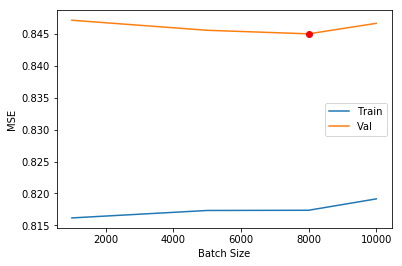

In [125]:
print("Validation MSE is lower when Batch Size B is around",best_B)
plt.plot(B_validation['Batch Size'][:4],B_validation['Train MSE'][:4],label='Train')
plt.plot(B_validation['Batch Size'][:4],B_validation['Validation MSE'][:4],label='Val')
plt.scatter(best_B,min(B_validation['Validation MSE']),color='r',zorder=5)
plt.xlabel('Batch Size')
plt.ylabel('MSE')
plt.legend()
plt.show()

#### ii. penalty

In [127]:
B=10000
ps=[0, 1e-5, .0001,.001,.01,.05,.1]
T = 20
r = 0.01
F = 1

train_list=[]
val_list=[]
results=[]

for p in ps:
    print(p)
    BU_guess,BI_guess,PU_guess,QI_guess = param_initial(F,U,I)
    BU, BI, PU, QI = Optimize_SGD(X, R, miu, BU_guess,BI_guess,PU_guess,QI_guess, F,
                                  penalty=p, learning_rate=r, batch_size=B, tol=1e-4, max_iter=T, verbose=False, report_time=2)
    
    train_mse,train_acc = loss_function(X, R, p, miu, BU, BI, PU, QI, msg='TRAIN')
    val_mse,val_acc=loss_function(X_val, R_val, p, miu, BU, BI, PU, QI, msg='VAL')
    train_list.append((train_mse,train_acc))
    val_list.append((val_mse,val_acc))
    results.append((p,train_mse,val_mse))     
        
p_validation = pd.DataFrame(results,columns=["Penalty","Train MSE","Validation MSE"])
best_p = p_validation["Penalty"][p_validation['Validation MSE'].idxmin(axis=0)]
print('Optimal penalty =',best_p)
p_validation

0
2019-11-21 01:33:59 | TRAIN Loss 0.799989
2019-11-21 01:33:59 | VAL Loss 0.831015
1e-05
2019-11-21 01:38:06 | TRAIN Loss 0.800388
2019-11-21 01:38:06 | VAL Loss 0.830539
0.0001
2019-11-21 01:42:14 | TRAIN Loss 0.800378
2019-11-21 01:42:14 | VAL Loss 0.830652
0.001
2019-11-21 01:46:24 | TRAIN Loss 0.798366
2019-11-21 01:46:24 | VAL Loss 0.829288
0.01
2019-11-21 01:50:33 | TRAIN Loss 0.801585
2019-11-21 01:50:33 | VAL Loss 0.831470
0.05
2019-11-21 01:54:57 | TRAIN Loss 0.804021
2019-11-21 01:54:57 | VAL Loss 0.834928
0.1
2019-11-21 01:59:04 | TRAIN Loss 0.810865
2019-11-21 01:59:05 | VAL Loss 0.841890
Optimal penalty = 0.001


,Penalty,Train MSE,Validation MSE
0,0.00000,0.799989,0.831015
1,0.00001,0.800388,0.830539
2,0.00010,0.800378,0.830652
3,0.00100,0.798366,0.829288
4,0.01000,0.801585,0.831470
5,0.05000,0.804021,0.834928
6,0.10000,0.810865,0.841890


Validation MSE is lower when Penalty p is around 0.001


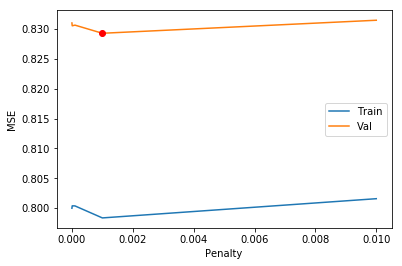

In [128]:
print("Validation MSE is lower when Penalty p is around",best_p)
plt.plot(p_validation['Penalty'][:5],p_validation['Train MSE'][:5],label='Train')
plt.plot(p_validation['Penalty'][:5],p_validation['Validation MSE'][:5],label='Val')
plt.scatter(best_p,min(p_validation['Validation MSE']),color='r',zorder=5)
plt.xlabel('Penalty')
plt.ylabel('MSE')
plt.legend()
plt.show()

#### iii. Epoch T

In [27]:
B=100000
p=0.001
Ts = [5,10,25,50,100,200]
r = 0.01
F = 1

train_list=[]
val_list=[]
results=[]

for T in Ts:
    print(T)
    BU_guess,BI_guess,PU_guess,QI_guess = param_initial(F,U,I)
    BU, BI, PU, QI = Optimize_SGD(X, R, miu, BU_guess,BI_guess,PU_guess,QI_guess, F,
                                  penalty=p, learning_rate=r, batch_size=B, tol=1e-4, max_iter=T, verbose=False, report_time=2)
    
    train_mse,train_acc = loss_function(X, R, p, miu, BU, BI, PU, QI, msg='TRAIN')
    val_mse,val_acc=loss_function(X_val, R_val, p, miu, BU, BI, PU, QI, msg='VAL')
    train_list.append((train_mse,train_acc))
    val_list.append((val_mse,val_acc))
    results.append((T,train_mse,val_mse))       
    
T_validation = pd.DataFrame(results,columns=["Epoch","Train MSE","Validation MSE"])
best_T = T_validation["Epoch"][T_validation['Validation MSE'].idxmin(axis=0)]
print('Optimal epoch =',best_T)
T_validation

5
2019-11-20 19:28:18 | TRAIN Loss 1.286769
2019-11-20 19:28:18 | VAL Loss 1.306351
10
2019-11-20 19:28:47 | TRAIN Loss 1.040348
2019-11-20 19:28:47 | VAL Loss 1.063581
25
2019-11-20 19:29:57 | TRAIN Loss 0.857511
2019-11-20 19:29:58 | VAL Loss 0.887148
50
2019-11-20 19:32:16 | TRAIN Loss 0.815843
2019-11-20 19:32:17 | VAL Loss 0.847670
100
2019-11-20 19:36:53 | TRAIN Loss 0.802834
2019-11-20 19:36:53 | VAL Loss 0.838271
200
2019-11-20 19:46:05 | TRAIN Loss 0.793768
2019-11-20 19:46:05 | VAL Loss 0.834654
Optimal epoch = 200


,Epoch,Train MSE,Validation MSE
0,5,1.286769,1.306351
1,10,1.040348,1.063581
2,25,0.857511,0.887148
3,50,0.815843,0.847670
4,100,0.802834,0.838271
5,200,0.793768,0.834654


Validation MSE is lower when Epoch T>50 and doesn't change a lot when T continues increasing.
      Considering timing consumption, we use T=50.


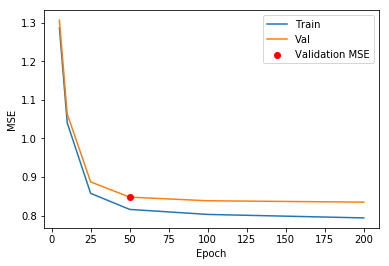

In [109]:
print("Validation MSE is lower when Epoch T>50 and doesn't change a lot when T continues increasing.\n\
      Considering timing consumption, we use T=50.")
best_T = 50
plt.plot(T_validation['Epoch'],T_validation['Train MSE'],label='Train')
plt.plot(T_validation['Epoch'],T_validation['Validation MSE'],label='Val')
plt.scatter(best_T,T_validation['Validation MSE'][T_validation['Epoch']==best_T],color='r',zorder=5)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

#### iv. Learning Rate

In [34]:
B=10000
p=0.001
T=10
rates = [.05,.01,.005,.001]
F = 1

train_list=[]
val_list=[]
results=[]

for r in rates:
    print(r)
    BU_guess,BI_guess,PU_guess,QI_guess = param_initial(F,U,I)
    BU, BI, PU, QI = Optimize_SGD(X, R, miu, BU_guess,BI_guess,PU_guess,QI_guess, F,
                                  penalty=p, learning_rate=r, batch_size=B, tol=1e-4, max_iter=T, verbose=False, report_time=2)   
    train_mse,train_acc = loss_function(X, R, p, miu, BU, BI, PU, QI, msg='TRAIN')
    val_mse,val_acc=loss_function(X_val, R_val, p, miu, BU, BI, PU, QI, msg='VAL')
    train_list.append((train_mse,train_acc))
    val_list.append((val_mse,val_acc))
    results.append((r,train_mse,val_mse))
    
r_validation = pd.DataFrame(results,columns=["Learning Rate","Train MSE","Validation MSE"])
best_r = r_validation["Learning Rate"][r_validation['Validation MSE'].idxmin(axis=0)]
print('Optimal rate =',best_r)
r_validation

0.05
2019-11-20 19:53:14 | TRAIN Loss 0.799392
2019-11-20 19:53:15 | VAL Loss 0.838488
0.01
2019-11-20 19:56:31 | TRAIN Loss 0.807028
2019-11-20 19:56:31 | VAL Loss 0.835022
0.005
2019-11-20 19:59:47 | TRAIN Loss 0.827964
2019-11-20 19:59:48 | VAL Loss 0.853542
0.001
2019-11-20 20:03:03 | TRAIN Loss 1.114780
2019-11-20 20:03:03 | VAL Loss 1.128223
Optimal rate = 0.01


,Learning Rate,Train MSE,Validation MSE
0,0.050,0.799392,0.838488
1,0.010,0.807028,0.835022
2,0.005,0.827964,0.853542
3,0.001,1.114780,1.128223


Validation MSE is lower when learning rate r is around 0.01


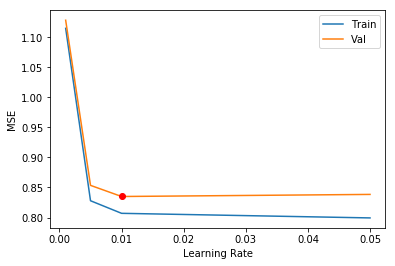

In [93]:
print("Validation MSE is lower when learning rate r is around",best_r)
plt.plot(r_validation['Learning Rate'],r_validation['Train MSE'],label='Train')
plt.plot(r_validation['Learning Rate'],r_validation['Validation MSE'],label='Val')
plt.scatter(best_r,min(r_validation['Validation MSE']),color='r',zorder=5)
plt.xlabel('Learning Rate')
plt.ylabel('MSE')
plt.legend()
plt.show()

#### v. F

In [100]:
B=10000
p=0.001
T = 50
r = 0.01
Fs = [0,1,2,3,5]

train_list=[]
val_list=[]
results=[]

for F in Fs:
    print(F)
    BU_guess,BI_guess,PU_guess,QI_guess = param_initial(F,U,I)
    BU, BI, PU, QI = Optimize_SGD(X, R, miu, BU_guess,BI_guess,PU_guess,QI_guess, F,
                                  penalty=p, learning_rate=r, batch_size=B, tol=1e-4, max_iter=T, verbose=False, report_time=2)
    
    train_mse,train_acc = loss_function(X, R, p, miu, BU, BI, PU, QI, msg='TRAIN')
    val_mse,val_acc=loss_function(X_val, R_val, p, miu, BU, BI, PU, QI, msg='VAL')
    train_list.append((train_mse,train_acc))
    val_list.append((val_mse,val_acc))
    results.append((F,train_mse,val_mse))
    
F_validation = pd.DataFrame(results,columns=["F","Train MSE","Validation MSE"])
best_F = F_validation["F"][F_validation['Validation MSE'].idxmin(axis=0)]
print('Better F is around',best_F)
F_validation

0
2019-11-20 23:41:54 | TRAIN Loss 0.805987
2019-11-20 23:41:54 | VAL Loss 0.824269
1
2019-11-20 23:49:30 | TRAIN Loss 0.779532
2019-11-20 23:49:30 | VAL Loss 0.817035
2
2019-11-20 23:57:22 | TRAIN Loss 0.758439
2019-11-20 23:57:22 | VAL Loss 0.813265
3
2019-11-21 00:05:13 | TRAIN Loss 0.744234
2019-11-21 00:05:14 | VAL Loss 0.816814
5
2019-11-21 00:13:27 | TRAIN Loss 0.736153
2019-11-21 00:13:27 | VAL Loss 0.845886
Better F is around 2


,F,Train MSE,Validation MSE
0,0,0.805987,0.824269
1,1,0.779532,0.817035
2,2,0.758439,0.813265
3,3,0.744234,0.816814
4,5,0.736153,0.845886


Validation MSE is lower when F is around 2


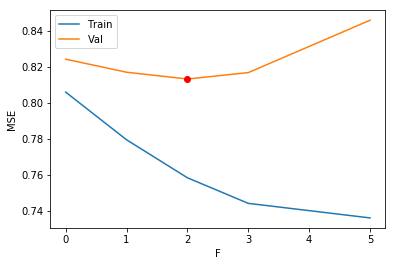

In [105]:
print("Validation MSE is lower when F is around",best_F)
plt.plot(F_validation['F'],F_validation['Train MSE'],label='Train')
plt.plot(F_validation['F'],F_validation['Validation MSE'],label='Val')
plt.scatter(best_F,min(F_validation['Validation MSE']),color='r',zorder=5)
plt.xlabel('F')
plt.ylabel('MSE')
plt.legend()
plt.show()

### 10. Candidate Models Selection (F)

In [110]:
class SGD_Rating_Prediction:
    def __init__(self, F=0, penalty=0, learning_rate=0.01,
                 batch_size=10000, tol=1e-4, max_iter=10,
                 verbose=False, report_time=1 ):
        self.F=F         
        self.penalty=penalty
        self.learning_rate=learning_rate
        self.batch_size=batch_size
        self.tol=tol
        self.max_iter=max_iter
        self.verbose=verbose
        self.report_time=report_time
        
    def fit(self,X,R,U,I):
        bu_guess,bi_guess,pu_guess,qi_guess = param_initial(self.F,U,I)
        self.miu = np.mean(R)
        self.bu, self.bi, self.pu, self.qi = Optimize_SGD(X, R, self.miu, bu_guess,bi_guess,pu_guess,qi_guess, 
                                                          F=self.F, penalty=self.penalty, learning_rate=self.learning_rate,
                                                          batch_size=self.batch_size, tol=self.tol, max_iter=self.max_iter,
                                                          verbose=self.verbose, report_time=self.report_time)
    def params(self):
        return self.bu, self.bi, self.pu, self.qi
    def predict(self,X):
        self.r_pred = rating_class(X, self.miu, self.bu, self.bi, self.pu, self.qi)
        return self.r_pred

In [192]:
def model_cross_validation(model,X,y,U,I,folds):
    kfolds=len(folds)
    train_performance=np.empty(kfolds)
    validation_performance=np.empty(kfolds)
    for idx in range(kfolds):
        train,validation=folds[idx]
        X_train=X[train]
        y_train=y[train]
        model.fit(X_train,y_train,U,I)
        train_mse = np.mean((y_train-model.predict(X_train))**2)
        X_validation=X[validation]
        y_validation=y[validation]
        validation_mse = np.mean((y_validation-model.predict(X_validation))**2)
        train_performance[idx]=train_mse
        validation_performance[idx]=validation_mse
        date_str=datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        print(f'Fold {idx}: {date_str} | Train MSE {train_mse:.6f} | Val MSE {validation_mse:.6f}')
    return np.array(train_performance),np.array(validation_performance)

In [193]:
print(f'Best batch-size: {best_B}\nBest penalty: {best_p}\nBest epoch: {best_T}\nBest learning rate: {best_r}\nBest F: {best_F}')

Best batch-size: 8000
Best penalty: 0.001
Best epoch: 50
Best learning rate: 0.01
Best F: 2


In [194]:
X_trainval=np.array(r_trainval[['U_ID','M_ID']])
R_trainval=np.array(r_trainval['Rating'])

U = len(pd.unique(u_df.U_ID))
I = len(pd.unique(m_df.M_ID))   

B=best_B  # 8000
p=best_p  # 0.001
T=best_T  # 50
r=best_r  # 0.01
F3 = [1,2,3]

kf=KFold(5,shuffle=True)
folds=list(kf.split(X_trainval))
results=[]

for F in F3:
    print('F =',F)
    model=SGD_Rating_Prediction(F=F, penalty=p, learning_rate=r, batch_size=B, max_iter=T,verbose=False,report_time=1)
    t,v = model_cross_validation(model,X_trainval,R_trainval,U,I,folds)
    results.append((F,t.mean(),v.mean()))
    
F_selection = pd.DataFrame(results,columns=["F","Train MSE","Validation MSE"])
best_final_F = F_selection["F"][F_selection['Validation MSE'].idxmin(axis=0)]
print('\nBest Model: F =',best_final_F)
F_selection

F = 1
Fold 0: 2019-11-21 03:01:50 | Train MSE 0.768358 | Val MSE 0.818228
Fold 1: 2019-11-21 03:13:45 | Train MSE 0.783707 | Val MSE 0.831247
Fold 2: 2019-11-21 03:24:48 | Train MSE 0.791987 | Val MSE 0.838261
Fold 3: 2019-11-21 03:35:50 | Train MSE 0.787686 | Val MSE 0.841456
Fold 4: 2019-11-21 03:46:52 | Train MSE 0.770463 | Val MSE 0.813626
F = 2
Fold 0: 2019-11-21 03:57:32 | Train MSE 0.743841 | Val MSE 0.817074
Fold 1: 2019-11-21 04:08:09 | Train MSE 0.742596 | Val MSE 0.811832
Fold 2: 2019-11-21 04:19:20 | Train MSE 0.743338 | Val MSE 0.810329
Fold 3: 2019-11-21 04:30:42 | Train MSE 0.739796 | Val MSE 0.816211
Fold 4: 2019-11-21 04:42:11 | Train MSE 0.737010 | Val MSE 0.806208
F = 3
Fold 0: 2019-11-21 04:53:53 | Train MSE 0.724273 | Val MSE 0.818726
Fold 1: 2019-11-21 05:05:34 | Train MSE 0.730281 | Val MSE 0.821195
Fold 2: 2019-11-21 05:17:15 | Train MSE 0.723107 | Val MSE 0.810331
Fold 3: 2019-11-21 05:28:58 | Train MSE 0.719073 | Val MSE 0.818888
Fold 4: 2019-11-21 05:40:40 | 

,F,Train MSE,Validation MSE
0,1,0.780440,0.828563
1,2,0.741316,0.812331
2,3,0.725382,0.818205


### 11. Test Set Performance

In [195]:
B=best_B  # 8000
p=best_p  # 0.001
T=best_T  # 50
r=best_r  # 0.01
F=best_final_F  # 2

MIU = np.mean(R_trainval)

BU_guess,BI_guess,PU_guess,QI_guess = param_initial(F,U,I)
BU, BI, PU, QI = Optimize_SGD(X_trainval,R_trainval, MIU, BU_guess,BI_guess,PU_guess,QI_guess, F,
                              penalty=p, learning_rate=r, batch_size=B, tol=1e-6, max_iter=T, verbose=True, report_time=1)

# Test Set
X_test=np.array(r_test[['U_ID','M_ID']])
R_test=np.array(r_test['Rating'])

test_mse,test_acc = loss_function(X_test, R_test, p, MIU, BU, BI, PU, QI, msg='TEST')
print(f'\nBest Model Test MSE: {test_mse:.6f}')

2019-11-21 05:40:41 | Original Loss 1.944208
2019-11-21 05:40:41 | TRAIN Loss 1.944208
2019-11-21 05:55:18 | TRAIN Loss 0.739379
2019-11-21 05:55:18 | TEST Loss 0.796596

Best Model Test MSE: 0.796596
